In [8]:
# from https://github.com/devnag/pytorch-generative-adversarial-networks

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# data params

data_mean = 4
data_sd = 1.25

# Model params
g_input_size = 1 # input a random noise
g_hidden_size = 100
g_output_size = 1

d_input_size = 100 # input minibatch
d_hidden_size = 50
d_output_size = 1 # Real or Fake
minibatch_size = d_input_size

d_learning_rate =2e-5
g_learning_rate =2e-5
optim_beta = (0.9, 0.999)
num_epochs = 30000
print_interval = 200
d_steps = 1  # training rate on d
g_steps = 1

# ### Uncomment only one of these
#(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)

(name, preprocess, d_input_func) = ("Data and Variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x*2)

print('Using Data [%s]' % (name))


Using Data [Data and Variances]


In [10]:
###### Data: target data + generator's random input data

def get_distribution_sampler(mu, stigma):  # Normal Distribution Target Data
    return lambda n: torch.Tensor(np.random.normal(mu, stigma, (1, n)))

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)

###### Models: g model and d model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.sigmoid(self.map2(x))
        x = self.map3(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.elu(self.map1(x))
        x = F.elu(self.map2(x))
        x = F.sigmoid(self.map3(x))
        return x

In [11]:
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)

d_sampler = get_distribution_sampler(data_mean, data_sd)
gi_sampler = get_generator_input_sampler()

G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss() # Binary Cross Entropy

d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_beta)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_beta)

# run the GAN

In [12]:
for epoch in range(num_epochs):
    for d_index in range(d_steps):  # train how many times per epoch
        # 1. Train D on real + fake
        D.zero_grad()
        
        # 1.1 Train D on real
        d_real_data = Variable(d_sampler(d_input_size))  # every time, create a new set of normal dist. data
                                                        # with numpy [1,100] input size
        d_real_decision = D(preprocess(d_real_data))  # Preprocess to add the variance in the next 100 values as [1,100]
                                                        # means, now the input numpy array is [1,200]
                                                        # then put into the D: Discriminator to 
        d_real_error = criterion(d_real_decision, Variable(torch.ones(1))) # ones is real, and all the real samples are real
        d_real_error.backward()  # BP in Discriminator
        
        # 1.2 Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))  # every time, create a new set of uniform dist. data.
                                                                        # with numpy [100, 1] input size
        d_fake_data = G(d_gen_input).detach() # IMPORTANT: detach the G model in this Discriminator's training
                                                # to avoid training G on these labels
        d_fake_decision = D(preprocess(d_fake_data.t()))  # 1st: transpose the output [100, 1] to [1, 100]
                                                            #preprocess to add the variance as before
                                                            # and put into the D
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(1))) # zeros = fake
        d_fake_error.backward()  # BP 2nd time in Discriminator
        d_optimizer.step()   # Only optimize D parameters
    
    for g_index in range(g_steps):
        # 2. Train G on D's reponse (but DO NOT train D on these labels)
        G.zero_grad()
        
        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
        g_fake_data = G(gen_input)
        dg_fake_decision = D(preprocess(g_fake_data.t()))
        g_error = criterion(dg_fake_decision, Variable(torch.ones(1)))
        
        g_error.backward()
        g_optimizer.step()  # Only optimize G's parameters
        
    if epoch % print_interval == 0:
        print("%s: \n\tD: %s/%s \n\tG: %s (Real: %s, Fake: %s\n\n) " % (epoch,
                                                           extract(d_real_error)[0],
                                                           extract(d_fake_error)[0],
                                                           extract(g_error)[0],
                                                           stats(extract(d_real_data)),
                                                           stats(extract(d_fake_data))))
        
        

        
        

0: 
	D: 0.960450291633606/0.6117495894432068 
	G: 0.7815150022506714 (Real: [4.109435591697693, 1.0478115699226633], Fake: [0.25096395224332807, 0.011216928543516157]

) 
200: 
	D: 0.24724139273166656/0.7340779304504395 
	G: 0.6575086116790771 (Real: [3.8750937211513521, 1.2296328841284401], Fake: [0.7159476542472839, 0.031099033110379898]

) 
400: 
	D: 0.24376854300498962/0.7516789436340332 
	G: 0.6405978202819824 (Real: [3.9589553463459013, 1.3156933663638324], Fake: [1.2715883874893188, 0.062331629218602087]

) 
600: 
	D: 0.20586958527565002/0.5891590714454651 
	G: 0.8132107257843018 (Real: [3.9610462963581083, 1.1473354440627435], Fake: [1.6492239820957184, 0.093218931104043903]

) 
800: 
	D: 0.27493947744369507/0.41207045316696167 
	G: 1.0880851745605469 (Real: [4.1773660135269166, 1.1900776623403129], Fake: [1.8006523990631103, 0.14072002889587421]

) 
1000: 
	D: 0.19012635946273804/0.31591174006462097 
	G: 1.284720540046692 (Real: [4.0574538165330889, 1.0800046266069072], Fake: 

In [17]:
d_fake_data.mean()

Variable containing:
 4.0976
[torch.FloatTensor of size 1]

In [14]:
d_fake_data.t()

Variable containing:

Columns 0 to 9 
 2.6421  4.9762  4.9099  3.6605  4.9133  3.2068  3.2556  1.2128  4.6405  4.8750

Columns 10 to 19 
 4.9206  1.4679  4.9114  2.2452  4.9841  4.8027  4.0996  4.6295  1.0627  4.9317

Columns 20 to 29 
 4.9654  4.5541  4.9681  2.0035  4.6235  4.9059  4.9117  4.5387  4.9293  4.3482

Columns 30 to 39 
 3.7267  4.9882  4.6924  2.0403  2.7674  4.9556  4.8169  1.3976  2.4600  4.8549

Columns 40 to 49 
 4.6632  1.0923  3.1289  4.9273  4.6444  4.7745  4.5708  4.8405  2.0023  1.9889

Columns 50 to 59 
 4.9691  4.2033  4.9812  0.9254  4.4897  2.9293  4.9708  2.9877  4.9508  4.3151

Columns 60 to 69 
 3.1709  1.3105  4.9690  4.3087  4.8409  4.7681  4.9797  4.8805  4.9752  4.2738

Columns 70 to 79 
 4.8113  4.5681  4.9379  4.8889  4.9809  4.9235  2.1977  4.4270  4.9750  3.0322

Columns 80 to 89 
 4.9765  4.3290  4.7503  4.2531  4.0633  4.9627  4.7380  4.7271  4.9697  1.0641

Columns 90 to 99 
 4.6159  4.9092  4.9783  4.7074  4.8971  4.8670  4.1339  3.5248  4.9533

## Dig Deeper

[[ 6.15339613  4.16190147  2.62423015  2.98374081  4.79948854  5.29628515
   4.62047291  3.76114655  3.13267255  3.81932688  2.78448296  4.24478626
   4.74561977  4.44313145  4.64703178  3.67684364  4.40762281  4.10781097
   3.96675086  4.97107792  3.43234563  5.46415281  5.09823275  5.26046371
   3.5444746   3.77776909  4.29387283  1.86991048  2.51971817  4.17556763
   4.87572098  5.15760088  4.65751505  3.42170572  4.13643837  1.95163918
   2.73850989  2.75134802  3.78412795  3.72884369  5.75201225  2.97849011
   4.49212933  5.43780279  6.62907171  2.12019253  3.31878114  2.71677542
   4.2525773   7.74324989  4.98329115  7.01721144  2.70801234  4.55108452
   4.1239934   6.97865534  3.61467934  2.47488236  4.66306639  4.77106428
   1.92913306  2.38413596  3.95918131  5.21180201  3.40874147  2.92393208
   4.14932871  4.93587446  2.68554997  5.81263542  4.75530481  6.25189114
   2.91022396  5.12980032  2.93874741  6.62317944  5.27265835  4.33529091
   5.14923477  5.02518177  6.36235809 

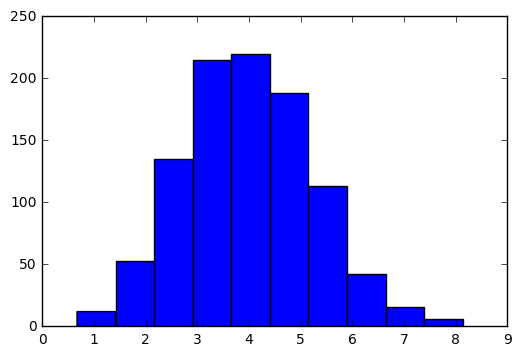

In [18]:
import matplotlib.pyplot as plt

sample_np = d_sampler(1000).numpy()

print(sample_np)
np.size(sample_np)

a_np = sample_np.copy()
a_x = [np.arange(100)]

print(a_x)
print(np.shape(a_x))
print(np.shape(a_np))

plt.hist(np.transpose(a_np)) 
plt.show()

In [134]:
print("%s: \n\tD: %s/%s \nG: %s \n(Real: %s, Fake: %s) " % (epoch,
                                                           extract(d_real_error)[0],
                                                           extract(d_fake_error)[0],
                                                           extract(g_error)[0],
                                                           stats(extract(d_real_data)),
                                                           stats(extract(d_fake_data))))

29999: 
	D: 0.5531200170516968/0.717462420463562 
G: 0.7971842288970947 
(Real: [4.1114702498912807, 1.1424093387516128], Fake: [3.9775783205032349, 1.2874585026157108]) 


## Analyzing the Comparison

In [135]:
# mean = torch.mean(d_real_data.data, 1)
# print(d_real_data.data)
# print(torch.mul(torch.ones(d_real_data.size()), mean.tolist()[0][0]))

# print(torch.cat([d_real_data, torch.pow(d_real_data - Variable(torch.mul(torch.ones(d_real_data.size()), mean.tolist()[0][0])), 2.0)], 1))
# print('\n\n\n')

In [136]:
# print(preprocess)

In [137]:
# print(preprocess(d_real_data))